In [20]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv', 'order_items')
]

# Folder containing the CSV files
folder_path = '/Users/andy-phucnguyen/Downloads/ecommerce'

# Function to infer SQL data types from pandas dtypes
def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

# Function to reconnect to MySQL if needed
def ensure_connection(conn, cursor):
    if not conn.is_connected():
        conn = mysql.connector.connect(
            host='localhost',
            user='root',
            password='phuc2005',
            database='ecommerce'
        )
        cursor = conn.cursor()
    return conn, cursor

# Initial connection
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='phuc2005',
    database='ecommerce'
)
cursor = conn.cursor()

for csv_file, table_name in csv_files:
    try:
        # Reconnect if needed
        conn, cursor = ensure_connection(conn, cursor)

        # Load the CSV
        file_path = os.path.join(folder_path, csv_file)
        df = pd.read_csv(file_path)

        # Replace NaN with None and clean column names
        df = df.where(pd.notnull(df), None)
        df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

        print(f"\n📄 Processing {csv_file} with shape {df.shape}")

        # Create table query
        columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
        create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
        cursor.execute(create_table_query)

        # Prepare insert query
        insert_query = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(df.columns))})"
        data = [tuple(None if pd.isna(x) else x for x in row) for row in df.to_numpy()]

        # Execute in batch
        cursor.executemany(insert_query, data)
        conn.commit()

        print(f"✅ Successfully inserted {len(data)} rows into `{table_name}`")

    except Exception as e:
        print(f"❌ Error processing {csv_file}: {e}")

# Final cleanup
cursor.close()
conn.close()
print("\n🔒 MySQL connection closed.")


📄 Processing customers.csv with shape (99441, 5)
✅ Successfully inserted 99441 rows into `customers`

📄 Processing orders.csv with shape (99441, 8)
✅ Successfully inserted 99441 rows into `orders`

📄 Processing sellers.csv with shape (3095, 4)
✅ Successfully inserted 3095 rows into `sellers`

📄 Processing products.csv with shape (32951, 9)
✅ Successfully inserted 32951 rows into `products`

📄 Processing geolocation.csv with shape (1000163, 5)
❌ Error processing geolocation.csv: 1153 (08S01): Got a packet bigger than 'max_allowed_packet' bytes

📄 Processing payments.csv with shape (103886, 5)
✅ Successfully inserted 103886 rows into `payments`

📄 Processing order_items.csv with shape (112650, 7)
✅ Successfully inserted 112650 rows into `order_items`

🔒 MySQL connection closed.


In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector


db = mysql.connector.connect(host = "localhost",
                            username = "root",
                            password = "phuc2005",
                            database = "ecommerce")

cur = db.cursor()

In [40]:
query = """ select distinct customer_city from customers """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


In [48]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp) = 2017 """

cur.execute(query)

data = cur.fetchall()

"total orders placed in 2017 are", data[0][0]

('total orders placed in 2017 are', 225505)

In [51]:
query = """ select upper(products.product_category) category, 
round(sum(payments.payment_value),2) sales
from products join order_items 
on products.product_id = order_items.product_id
join payments 
on payments.order_id = order_items.order_id
group by category
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Category", "Sales"])
df

,Category,Sales
0,PERFUMERY,3.243127e+07
1,FURNITURE DECORATION,9.153129e+07
2,TELEPHONY,3.116045e+07
3,BED TABLE BATH,1.096034e+08
4,AUTOMOTIVE,5.454684e+07
...,...,...
69,CDS MUSIC DVDS,7.676352e+04
70,LA CUISINE,1.864659e+05
71,FASHION CHILDREN'S CLOTHING,5.028288e+04
72,PC GAMER,1.391635e+05


In [53]:
query = """ select ((sum(case when payment_installments >= 1 then 1
else 0 end))/count(*))*100 from payments
"""

cur.execute(query)

data = cur.fetchall()

"the percentage of orders that were paid in installments is", data[0][0]

('the percentage of orders that were paid in installments is',
 Decimal('99.9981'))

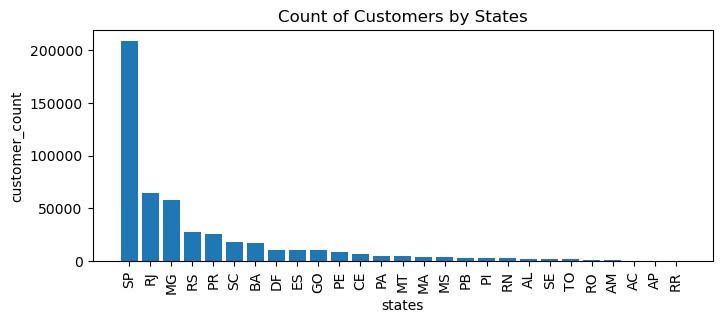

In [55]:
query = """ select customer_state ,count(customer_id)
from customers group by customer_state
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["state", "customer_count" ])
df = df.sort_values(by = "customer_count", ascending= False)

plt.figure(figsize = (8,3))
plt.bar(df["state"], df["customer_count"])
plt.xticks(rotation = 90)
plt.xlabel("states")
plt.ylabel("customer_count")
plt.title("Count of Customers by States")
plt.show()

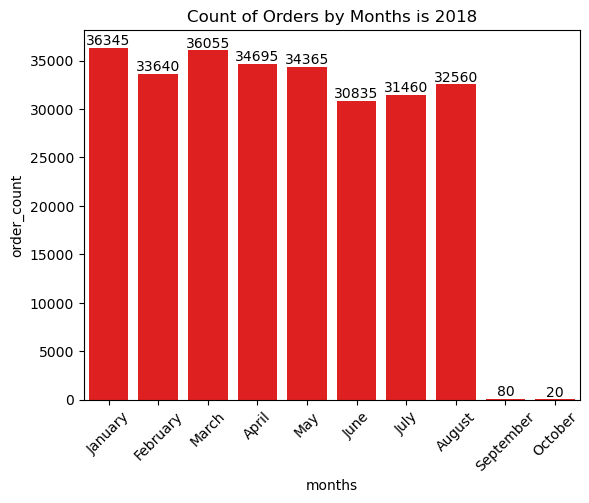

In [57]:
query = """ select monthname(order_purchase_timestamp) months, count(order_id) order_count
from orders where year(order_purchase_timestamp) = 2018
group by months
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["months", "order_count"])
o = ["January", "February","March","April","May","June","July","August","September","October"]

ax = sns.barplot(x = df["months"],y =  df["order_count"], data = df, order = o, color = "red")
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.title("Count of Orders by Months is 2018")

plt.show()

In [59]:
query = """with count_per_order as 
(select orders.order_id, orders.customer_id, count(order_items.order_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city, round(avg(count_per_order.oc),2) average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city order by average_orders desc
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data,columns = ["customer city", "average products/order"])
df.head(10)

,customer city,average products/order
0,padre carvalho,140.00
1,celso ramos,130.00
2,datas,120.00
3,candido godoi,120.00
4,matias olimpio,100.00
5,cidelandia,80.00
6,curralinho,80.00
7,picarra,80.00
8,morro de sao paulo,80.00
9,teixeira soares,80.00


In [61]:
query = """select upper(products.product_category) category, 
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales_percentage
from products join order_items 
on products.product_id = order_items.product_id
join payments 
on payments.order_id = order_items.order_id
group by category order by sales_percentage desc"""


cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Category", "percentage distribution"])
df.head()

,Category,percentage distribution
0,BED TABLE BATH,171.16
1,HEALTH BEAUTY,165.65
2,COMPUTER ACCESSORIES,158.45
3,FURNITURE DECORATION,142.94
4,WATCHES PRESENT,142.84


In [65]:
import numpy as np
cur = db.cursor()
query = """select products.product_category, 
count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Category", "order_count","price"])

arr1 = df["order_count"]
arr2 = df["price"]

a = np.corrcoef([arr1,arr2])
print("the correlation is", a[0][-1])

the correlation is -0.10631514167157562


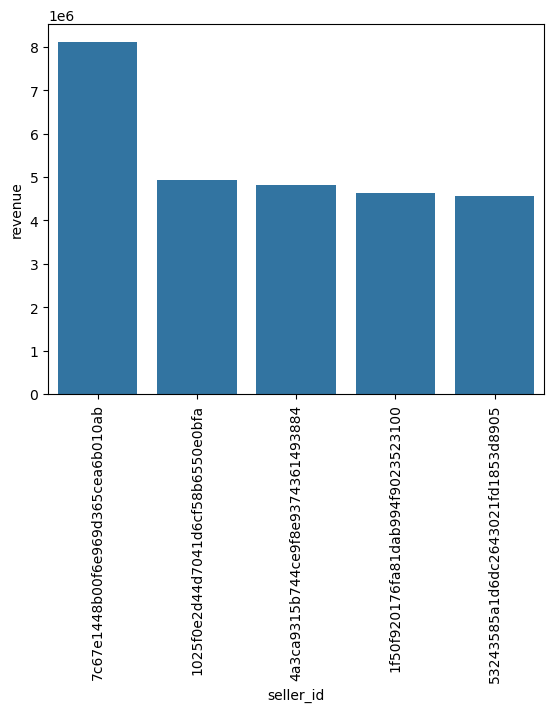

In [67]:
query = """ select *, dense_rank() over(order by revenue desc) as rn from
(select order_items.seller_id, sum(payments.payment_value)
revenue from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["seller_id", "revenue", "rank"])
df = df.head()
sns.barplot(x = "seller_id", y = "revenue", data = df)
plt.xticks(rotation = 90)
plt.show()

In [69]:
query = """select customer_id, order_purchase_timestamp, payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id, orders.order_purchase_timestamp, 
payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as a"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df

,0,1,2,3
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
4,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
...,...,...,...,...
2077715,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
2077716,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
2077717,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
2077718,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001


In [71]:
query = """select years, months , payment, sum(payment)
over(order by years, months) cumulative_sales from 
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years, months order by years, months) as a
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df

,0,1,2,3
0,2016,9,5044.80,5.044800e+03
1,2016,10,1181809.60,1.186854e+06
2,2016,12,392.40,1.187247e+06
3,2017,1,2769760.80,3.957008e+06
4,2017,2,5838160.19,9.795168e+06
5,2017,3,8997271.99,1.879244e+07
6,2017,4,8355760.59,2.714820e+07
7,2017,5,11858376.40,3.900658e+07
8,2017,6,10225527.61,4.923210e+07
9,2017,7,11847658.39,6.107976e+07


In [73]:
query = """with a as(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years order by years)

select years, ((payment - lag(payment, 1) over(order by years))/
lag(payment, 1) over(order by years)) * 100 from a"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years", "yoy % growth"])
df

,years,yoy % growth
0,2016,NaN
1,2017,12112.703758
2,2018,20.000924


In [75]:
query = """with a as (select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < 
date_add(first_order, interval 6 month)
group by a.customer_id) 

select 100 * (count( distinct a.customer_id)/ count(distinct b.customer_id)) 
from a left join b 
on a.customer_id = b.customer_id ;"""

cur.execute(query)
data = cur.fetchall()

data

[(None,)]

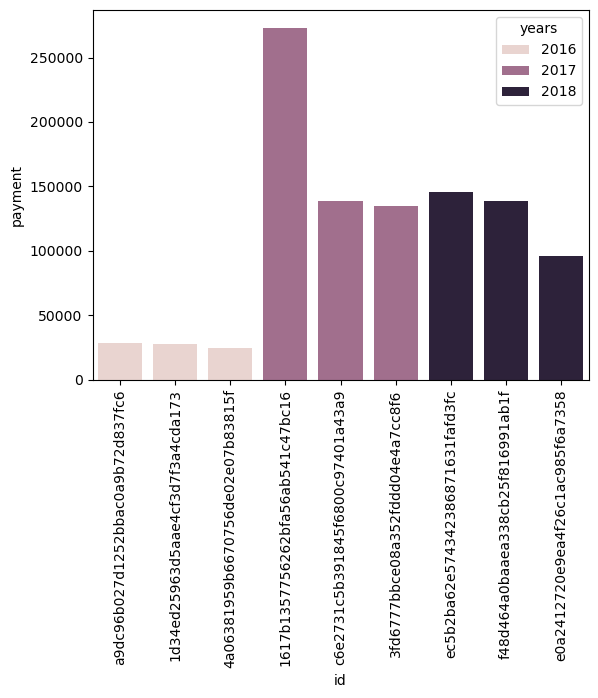

In [77]:
query = """select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments 
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <= 3 ;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","id","payment","rank"])
sns.barplot(x = "id", y = "payment", data = df, hue = "years")
plt.xticks(rotation = 90)
plt.show()